Computing a semi analytical solution to the Sedov-Taylor blast wave with radiation using the semi-analytical solution. 
-------------------------------------------------------------------------------------------------------------------------------------
See Reinicke (1998), Krumholz (2007) or Duval (2020) for discussion of the physics and computational aspects.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Code written by Hannah Duval, Eva Punter and Mathijs Vanrespaille. 
If you use this code in your publication, we kindly request you cite the following report: <br>
H. Duval & E. Punter & M. Vanrespaille, Benchmarking a new RHD-code: The Radiation-Sedov Blast Wave, 2020, KU Leuven

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as solver

In [2]:
# Input constanten
n = 3          # Aantal dimensies
a = -2         # Macht afhankelijkheid warmtegeleiding van dichtheid 
b = 13/2       # Macht afhankelijkheid warmtegeleiding van temperatuur
gamma = 5/4    # Adiabatische exponent
g_0 = 1        # Constante dichtheid
chi_0 = 1      # Constante warmtegeleiding
E_0 = 135      # Vrijgelaten energie
#Gamma = 8.31    #Welke eenheden horen we hierbij te gebruiken? 
Gamma = 1      #Gasconstante

C = [n, a, b]

In [3]:
# Handige constanten die aan de hand van de input berekend worden

k_p = ( (2*b-1)*n + 2 ) / ( 2*b - 2*a +1 )  # Macht afhankelijkheid dichtheid van straal (minteken ervoor)
kappa = -k_p                                # Macht afhankelijkheid dichtheid van straal (zonder minteken ervoor)
alpha = ( 2*b - 2*a + 1 ) / ( 2*b - (n+2)*a + n )  
Omega = 2*chi_0 / ( Gamma**(b+1) * g_0**(1-a) ) * ( E_0 / g_0 )**(b-1/2)   # Maat voor de sterkte van de explosie
sigma = ( 2*b-1 ) / ( alpha*(1-a) )
mu = 2/(gamma-1)

In [4]:
# RHS van vgl (13.a) in Reinicke (1991)
def f1(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    return -2*( 1 + W/(beta * H**(a-1) * Theta**b) )

In [5]:
# RHS van vgl (13.b) in Reinicke (1991)
def f2(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    return sigma - (n+kappa+sigma)*U

In [6]:
# RHS van vgl (13.c) in Reinicke (1991)
def f3(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    return U*(1/alpha-U) + Theta*(2*W/(beta * H**(a-1) * Theta**b) - kappa - sigma)

In [7]:
# RHS van vgl (13.d) in Reinicke (1991)
def f4(y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    if Theta < 1.e-10:
        return mu*(1/alpha-1) - n*U - (n+kappa+sigma)*W #waarom?
    else: 
        return W / (beta * H**(a-1) * Theta**b) * (mu*(U-1) + 2*W) + mu*(1/alpha-1) - n*U - (n+kappa+sigma)*W

In [8]:
# Berekening van initiële waarden voor de tweede integratie aan de binnenkant van de shock wave (discontinuïteit)
def shockConditions(y) :
    
    U_out = y[0]
    Theta_out = y[1]
    H_out = y[2]
    W_out = y[3]
    
    U_in = 1 - Theta_out / (1 - U_out)
    Theta_in = Theta_out
    H_in = H_out * (1 - U_out)**2 / Theta_out
    W_in = ( Theta_out*W_out - ((1-U_out)**4-Theta_out**2)/(2*(1-U_out)) ) / (1-U_out)**2
    
    new = (U_in, Theta_in, H_in, W_in)
    return new

In [9]:
# Berekening van de afgeleide van U naar ksi (niet logaritmisch) volgens Mathijs's berekeningen 
def dU(ksi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return (Theta*f2(y, beta) - (U-1)*f3(y, beta)) / (Theta - (U-1)**2) / ksi

In [10]:
# Berekening van de afgeleide van Theta naar ksi (niet logaritmisch) volgens Mathijs's berekeningen 
def dTheta(ksi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return f1(y, beta)*Theta/ksi

In [11]:
# Berekening van de afgeleide van H naar ksi (niet logaritmisch) volgens Mathijs's berekeningen 
def dH(ksi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return ( f3(y, beta) - (U-1)*f2(y, beta) ) / ( Theta - (U-1)**2 ) * H/ksi

In [12]:
# Berekening van de afgeleide van W naar ksi (niet logaritmisch) volgens Mathijs's berekeningen 
def dW(ksi, y, beta) : 
    U = y[0]
    Theta = y[1]
    H = y[2]
    W = y[3]
    
    return ( f4(y, beta) - ( (W-U+1)*f3(y, beta) + (Theta - (U-1)*W)*f2(y, beta) ) / (Theta - (U-1)**2) ) / ksi

In [13]:
# Functie die de vier afgeleiden bijeen brengt. Dit geef je mee aan scipy.integrate.solve_ivp en specifieer dat er een extra argument is door args=[beta] mee te geven.
def update(ksi, y, beta) :
    return (dU(ksi, y, beta), dTheta(ksi, y, beta), dH(ksi, y, beta), dW(ksi, y, beta))

In [14]:
###############################################################
# Below are initial conditions as described in Reinicke 1991:
# sec C. The singularity at a heat wave front
###############################################################

#integrand 26.d
def integrand_IC(y):
    F_y = y**(b-1) * (1-y)**(b-a) * (1-2*y)/(mu - (mu + 1)*y)
    return F_y

def Initial_conditions(xi_f, beta, U_0):

    Int, err = solver.quad(integrand_IC, 0, U_0)
    Fac = -beta*xi_f**((2*b-1)/a)

    ln_x = Fac*Int
    xi_new = np.exp(ln_x)*xi_f #24
    
    #rest 26
    Theta_0 = U_0*(1-U_0)
    G_0 = 1./(1-U_0)
    H_0 = xi_new**(-sigma)*G_0
    W_0 =  (mu - (mu+1)*U_0)/2
    
    return xi_new, [U_0, Theta_0, H_0, W_0]

###############################################################
###############################################################

In [15]:
#Condities voor een event, moet 0 returnen als een event voorkomt. Een event vindt plaats als U = 1+sqrt(Theta) of U = 1-sqrt(Theta)
def supersonic(t, y, beta) :
    return (y[0] - (1+np.sqrt(y[1])) ) * (y[0] - (1-np.sqrt(y[1])) )
supersonic.terminal = True
#Dit laatste betekent dat de integratie stopgezet moet worden als een event plaatsvindt.

In [16]:
#Eenvoudige functie die een begin- en eindpunt voor de buitenste en binnenste integratie resp. vraagt en een waarde voor beta, evenals een beginwaarde voor U.
# Voert alle berekeningen van de binnenste en buitenste integralen uit en geeft je beide oplossingen volledig.
def integration(ksi_f, ksi_0, beta, U_0) :
    
    xi_new, initial_out = Initial_conditions(ksi_f, beta, U_0)
    sol_out = solver.solve_ivp(update, (xi_new, 1.0), initial_out, method="LSODA", rtol=1e-6, args = [beta], events = supersonic)
    final_out = (sol_out.y[0][-1], sol_out.y[1][-1], sol_out.y[2][-1], sol_out.y[3][-1])
    initial_in = shockConditions(final_out)
    sol_in = solver.solve_ivp(update, (1.0, ksi_0), initial_in, method="LSODA", rtol=1e-6, events = supersonic, args=[beta])
    
    return sol_out, sol_in

In [17]:
# Vraagt om beide oplossingen en haalt de arrays eruit en plakt die samen. 
def appendSolutions(sol_out, sol_in) :
    
    Ksi = np.append(sol_out.t, sol_in.t)
    U = np.append(sol_out.y[0], sol_in.y[0])
    Theta = np.append(sol_out.y[1], sol_in.y[1])
    H = np.append(sol_out.y[2], sol_in.y[2])
    W = np.append(sol_out.y[3], sol_in.y[3])
    G = H * Ksi**sigma
    return Ksi, U, Theta, H, W, G

In [18]:
#Vraagt om beide oplossingen en geeft 6 plots. 5 van de dimensieloze grootheden in de volgorde U, Theta, H, G, W tegen ksi.
# Laatste plot is de U-sqrt(Theta) plot met de lijnen die events voorstellen. 
def plotIntegration(sol_out, sol_in) :
    Ksi, U, Theta, H, W, G = appendSolutions(sol_out, sol_in)
    fig, ax = plt.subplots(3, 2, figsize=(10,15))
    
    ax[0][0].plot(Ksi, U, color='blue')
    ax[0][0].set_title("Dimensionless speed", fontsize=16)
    ax[0][0].set_xlabel('$\\xi$', fontsize=14)
    ax[0][0].set_ylabel("U", fontsize=14)
    ax[0][0].grid()

    ax[0][1].plot(Ksi, Theta, color='blue')
    ax[0][1].set_title("Dimensionless temperature", fontsize=16)
    ax[0][1].set_xlabel("$\\xi$", fontsize=14)
    ax[0][1].set_ylabel("$\\Theta$", fontsize=14)
    ax[0][1].grid()
    
    ax[1][0].plot(Ksi, H, color='blue')
    ax[1][0].set_title("Dimensionless density H", fontsize=16)
    ax[1][0].set_xlabel("$\\xi$", fontsize=14)
    ax[1][0].set_ylabel("H", fontsize=14)
    ax[1][0].grid()
    
    ax[1][1].plot(Ksi, G, color='blue')
    ax[1][1].set_title("Dimensionless density G", fontsize=16)
    ax[1][1].set_xlabel("$\\xi$", fontsize=14)
    ax[1][1].set_ylabel("G", fontsize=14)
    ax[1][1].grid()
    
    ax[2][0].plot(Ksi, W, color='blue')
    ax[2][0].set_title("Something", fontsize=16)
    ax[2][0].set_xlabel("$\\xi$", fontsize=14)
    ax[2][0].set_ylabel("W", fontsize=14)
    ax[2][0].grid()
    
    ax[2][1].plot(np.sqrt(sol_out.y[1]), sol_out.y[0], color='blue')
    ax[2][1].plot(np.sqrt(sol_in.y[1]), sol_in.y[0], color='red')
    ax[2][1].plot([np.sqrt(sol_out.y[1][-1]), np.sqrt(sol_in.y[1][0])], [sol_out.y[0][-1], sol_in.y[0][0]], 'k--')
    ax[2][1].plot([0, np.sqrt(np.max(Theta))], [1, 1-np.sqrt(np.max(Theta))], color='black')
    ax[2][1].plot([0, np.sqrt(np.max(Theta))], [1, 1+np.sqrt(np.max(Theta))], color='black')
    ax[2][1].set_title("U - $\\Theta$ plane", fontsize=16)
    ax[2][1].set_xlabel("$\\sqrt{\\Theta}$", fontsize=14)
    ax[2][1].set_ylabel("U", fontsize=14)
    ax[2][1].grid()
    
    fig.tight_layout()
    return

In [19]:
# Voert beide integraties uit en checkt voor mogelijkse events (die alleen in sol_in voorkomen). Geeft 3 terug als er geen event is.
# Geeft 1 terug als beta te klein was. Geeft 2 terug als beta te groot is. 
def detectEvent(C, ksi_f, ksi_0, beta) :
# Ik neem aan dat de integratie stopgezet wordt zodra een event voorkomt. Dan zoeken we gewoon de laatste U en Theta en checken welk event voorkwam.

    xi_new, initial_out = Initial_conditions(ksi_f, beta, 1.e-3)
    sol_out = solver.solve_ivp(update, (xi_new, 1.0), initial_out, method="LSODA", rtol=1e-6, args=[beta])
    final_out = (sol_out.y[0][-1], sol_out.y[1][-1], sol_out.y[2][-1], sol_out.y[3][-1])
    initial_in = shockConditions(final_out)
    solution = solver.solve_ivp(update, (1.0, ksi_0), initial_in, method="LSODA", rtol=1e-6, events = supersonic, args=[beta])

    if len(solution.t_events[0]) == 0 :
        return 3
    U_event = solution.y[0][-1]
    Theta_event = solution.y[1][-1]
    #if U_event < 1 - np.sqrt(Theta_event) :# Werkt niet aangezien de integratie stopt bij een event en nooit over de lijn gaat.
    if U_event < 1 :
        return 1
    #if U_event > 1 + np.sqrt(Theta_event) :
    if U_event > 1 :
        return 2
    return None

In [20]:
# Berekent een acceptabele beta die bij een integratie van ksi_f tot ksi_0 geen events oplevert. Het interval halveert telkens 
# en als het interval kleiner wordt dan een gegeven relatieve tolerantie, stopt de berekening en print het een waarschuwing.
def bisectionBeta(C, ksi_f, ksi_0, beta_min, beta_max, tolerance) :    
    beta_mid = (beta_min + beta_max)/2
    if (beta_max - beta_min) / beta_mid < tolerance :
        print('Interval smaller than the relative tolerance.')
        return beta_mid
    
    event = detectEvent(C, ksi_f, ksi_0, beta_mid)
    if not (event in [1,2,3]) :
        raise Exception('Not a valid event.')

    if event == 1 :
        return bisectionBeta(C, ksi_f, ksi_0, beta_mid, beta_max, tolerance)
    if event == 2 :
        return bisectionBeta(C, ksi_f, ksi_0, beta_min, beta_mid, tolerance)    
    if event == 3 :
        
        print('The shock was reached.')
        return beta_mid
    
    return None

In [21]:
# Berekent Omega aan de hand van die lelijke integraal in vgl 78 van Krumholz.
def eq78(C, ksi_f, ksi_0, beta) : 
    n = C[0]
    a = C[1]
    b = C[2]
    
    xi_new, initial_out = Initial_conditions(ksi_f, beta, 1.e-3)
    sol_out = solver.solve_ivp(update, (xi_new, 1.0), initial_out, method="LSODA", rtol=1e-6, args=[beta], t_eval = np.linspace(xi_new, 1, 1000))
    final_out = (sol_out.y[0][-1], sol_out.y[1][-1], sol_out.y[2][-1], sol_out.y[3][-1])
    initial_in = shockConditions(final_out)
    sol_in = solver.solve_ivp(update, (1.0, ksi_0), initial_in, method="LSODA", rtol=1e-6, events = supersonic, args=[beta], t_eval = np.linspace(1, ksi_0, 1000))
    
    ksi, U, Theta, H, W, G = appendSolutions(sol_out, sol_in)
    
    Omega = 0
    for i in range(len(ksi)-1) :
        
        ksi_gem = (ksi[i] + ksi[i+1])/2
        U_gem = (U[i] + U[i+1])/2
        Theta_gem = (Theta[i] + Theta[i+1])/2
        G_gem = (G[i] + G[i+1])/2
        Omega += (ksi[i]-ksi[i+1]) * ksi_gem**(n-k_p+1) * G_gem * (U_gem**2 + mu*Theta_gem)
    
    return beta * (2*np.pi*Omega)**(b-1/2)

In [22]:
#Zoekt een ksi_f die voor een gegeven ksi_0 een Omega oplevert die binnen een relatieve tolerantie van de gewenste omega ligt. 
#Loopt vast als een acceptabel paar (ksi_f, beta) niet gevonden wordt.
def bisectionOmega(C, ksi_min, ksi_max, ksi_0, beta_min, beta_max, Omega_wanted, toleranceKsi, toleranceBeta, toleranceOmega) :
    ksi_mid = (ksi_min + ksi_max)/2
    beta_mid = bisectionBeta(C, ksi_mid, ksi_0, beta_min, beta_max, toleranceBeta)
    Omega_mid = eq78(C, ksi_mid, ksi_0, beta_mid)
    print((ksi_mid, beta_mid, Omega_mid))
    
    if (ksi_max - ksi_min)/ksi_mid < toleranceKsi :
        print('Interval xi smaller than given tolerance.')
        #return (ksi_mid, beta_mid, Omega_mid)
    
    if Omega_mid > Omega_wanted / (1+toleranceOmega) and Omega_mid < Omega_wanted * (1+toleranceOmega) :
        return (ksi_mid, beta_mid, Omega_mid)
    
    if Omega_mid < Omega_wanted :
        return bisectionOmega(C, ksi_mid, ksi_max, ksi_0, beta_min, beta_max, Omega_wanted, toleranceKsi, toleranceBeta, toleranceOmega)
        #print('smaller')
    if Omega_mid > Omega_wanted :
        return bisectionOmega(C, ksi_min, ksi_mid, ksi_0, beta_min, beta_max, Omega_wanted, toleranceKsi, toleranceBeta, toleranceOmega)
    return None

In [23]:
#Berekent de constante zeta die in ksi voorkomt aan de hand van vergelijking 76 in Krumholz.
def zeta(beta) :
    return ( beta * Gamma**(b+1) * g_0**(1-a) / ( 2*chi_0 * alpha**(2*b-1) ) )**(alpha/(2*b-1))

In [24]:
# Rekent de gevonden waarden voor de dimensieloze grootheden om naar de fysieke grootheden met eenheden volgens vergelijking **** in ****
def convertToPhysical(sol_out, sol_in, zeta, t, normalise = False) : 
    ksi_norm = sol_out.t[-1]
    r_norm = ksi_norm * zeta * t**alpha
    
    Ksi, U, Theta, H, W, G = appendSolutions(sol_out, sol_in)
    r = Ksi * zeta * t**alpha
    rho = G * g_0 * r**kappa
    v = U * r * alpha / t
    T = Theta * (alpha*r/t)**2
    
    if normalise:
        return r/r_norm, v/np.max(v), T/np.max(T), rho/np.max(rho)
    return r, v, T, rho

In [25]:
# Maakt drie plots van de drie fysieke grootheden die ons interesseren. 
def plotPhysical(sol_out, sol_in, zeta, t, normalise = False) :
    r, v, T, rho = convertToPhysical(sol_out, sol_in, zeta, t, normalise = normalise)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].plot(r, v)
    ax[0].set_title('Speed gas', fontsize=18)
    ax[0].set_xlabel('r [a.u.]', fontsize=16)
    ax[0].set_ylabel('v [a.u.]', fontsize=16)
    ax[0].grid()
    
    ax[1].plot(r, T)
    ax[1].set_title('Temperature gas', fontsize=18)
    ax[1].set_xlabel('r [a.u.]', fontsize=16)
    ax[1].set_ylabel('T [a.u.]', fontsize=16)
    ax[1].grid()
    
    ax[2].plot(r, rho)
    ax[2].set_title('Density gas', fontsize=18)
    ax[2].set_xlabel('r [a.u.]', fontsize=16)
    ax[2].set_ylabel('$\\rho$ [a.u.]', fontsize=16)
    ax[2].grid()
    
    plt.tight_layout()
    plt.show()
    return fig

In [26]:
# Deze cel waarin we met realistische waarden bisectionOmega uitproberen doet wat lastig. Ik stel daarom voor dat we enkel 
# bisectionBeta gebruiken en met de hand wat verder zoeken naar een goede ksi_0 met behulp van eq78.

ksi_0 = 0.005
ksi_f = 2
#beta_0 = 7.17e7
beta_0 = bisectionBeta(C, ksi_f, ksi_0, 10**6, 10**8, 10**-6)
omega_wanted = eq78(C, ksi_f, ksi_0, beta_0)

ksi_found, beta_found, omega_found = bisectionOmega(C, 1, 3.5, ksi_0, 10**7, 10**8, omega_wanted, 10**-7, 10**-8, 1e-2)
display( (ksi_found, beta_found, beta_0, omega_found, omega_wanted) )

The shock was reached.
The shock was reached.
(2.25, 80320739.74609375, 456618023057182.06)
Interval smaller than the relative tolerance.
(1.625, 99999999.66472387, 184971688330.7174)
The shock was reached.
(1.9375, 69648208.61816406, 301880876383255.75)
The shock was reached.
(2.09375, 75304107.66601562, 375321667907618.2)
The shock was reached.
(2.015625, 72571945.19042969, 337737019382152.6)
The shock was reached.
(1.9765625, 71121749.87792969, 319416485532026.25)
The shock was reached.
(1.99609375, 71856117.24853516, 328562809759289.94)


(1.99609375,
 71856117.24853516,
 72000656.12792969,
 328562809759289.94,
 330393105009191.9)

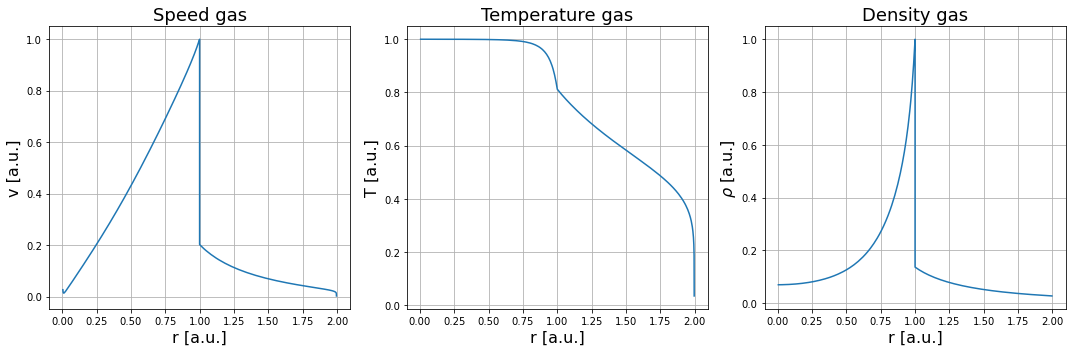

In [27]:
sol_outer, sol_inner = integration(ksi_found, ksi_0, beta_found, 1e-3)
zeta_found = zeta(beta_found)
fig = plotPhysical(sol_outer, sol_inner, zeta_found, 1, normalise = True)
fig.savefig('Physical quantities t_0022', dpi=400)

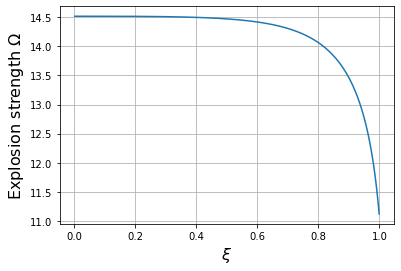

In [28]:
# Een plot die toont hoe de berekening van Omega afhangt van de gekozen binnenste waarde.
# Duidelijk is dat zodra een waarde voldoende klein is, die verder verminderen weinig verbetering brengt.
# Ik steek dit nog in een back-up slide!

XI = np.linspace(0.001, 0.999, 999)
OMEGA = []
for xi in XI: 
    OMEGA.append( np.log(eq78(C, 2, xi, beta_0))/np.log(10) )

fig, ax = plt.subplots(1,1)
plt.plot(XI, OMEGA)
plt.xlabel('$\\xi$', fontsize=16)
plt.ylabel('Explosion strength $\\Omega$', fontsize=16)
plt.grid()
plt.show()
fig.savefig('Omega plot', dpi=400)

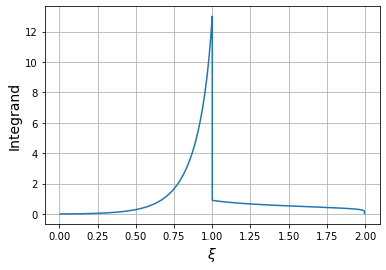

In [29]:
# Een plot van de integrand van vergelijking 78 in Krumholz waarmee we de sterkte van de explosie berekenen. 

Ksi, U, Theta, H, W, G = appendSolutions(sol_outer, sol_inner)

fig, ax = plt.subplots(1,1)
ax.plot(Ksi, Ksi**(n-k_p+1) * G * (U**2 + mu*Theta))
ax.set_xlabel('$\\xi$', fontsize=14)
ax.set_ylabel('Integrand', fontsize=14)
plt.grid()
plt.show()
fig.savefig('Integrand eq78', dpi=400)

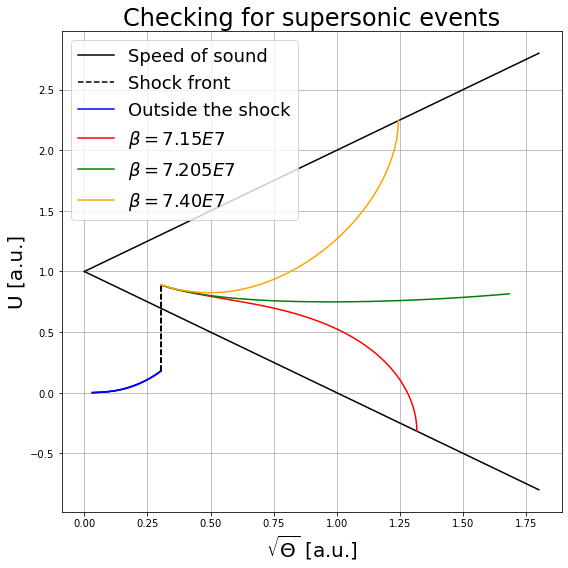

In [30]:
#Plot die we in de slides steken om te tonen hoe de bisectie voor beta werkt. Negeer maar.

sol_out1, sol_in1 = integration(2, 0.2, 7.15e7, 10**-3)
sol_out2, sol_in2 = integration(2, 0.2, 7.205e7, 10**-3)
sol_out3, sol_in3 = integration(2, 0.2, 7.4e7, 10**-3)

fig, ax = plt.subplots(1,1, figsize=(8,8))

plt.plot([0, 1.8], [1, -0.8], color='black', label="Speed of sound")
plt.plot([0, 1.8], [1, 2.8], color='black')
plt.title("Checking for supersonic events", fontsize=24)
plt.xlabel("$\\sqrt{\\Theta}$ [a.u.]", fontsize=20)
plt.ylabel("U [a.u.]", fontsize=20)

plt.plot([np.sqrt(sol_out1.y[1][-1]), np.sqrt(sol_in1.y[1][0])], [sol_out1.y[0][-1], sol_in1.y[0][0]], 'k--', label="Shock front")
plt.plot(np.sqrt(sol_out1.y[1]), sol_out1.y[0], color='blue', label="Outside the shock")
plt.plot(np.sqrt(sol_in1.y[1]), sol_in1.y[0], color='red', label="$\\beta = 7.15E7$")

plt.plot(np.sqrt(sol_out2.y[1]), sol_out2.y[0], color='blue')
plt.plot(np.sqrt(sol_in2.y[1]), sol_in2.y[0], color='green', label="$\\beta = 7.205E7$")
plt.plot([np.sqrt(sol_out2.y[1][-1]), np.sqrt(sol_in2.y[1][0])], [sol_out2.y[0][-1], sol_in2.y[0][0]], 'k--')

plt.plot(np.sqrt(sol_out3.y[1]), sol_out3.y[0], color='blue')
plt.plot(np.sqrt(sol_in3.y[1]), sol_in3.y[0], color='orange', label="$\\beta = 7.40E7$")
plt.plot([np.sqrt(sol_out3.y[1][-1]), np.sqrt(sol_in3.y[1][0])], [sol_out3.y[0][-1], sol_in3.y[0][0]], 'k--')


plt.legend(fontsize=18)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.grid()             
plt.tight_layout()